In [1]:
import tensorflow as tf

%load_ext autoreload

In [51]:
%autoreload
from unet import UnetTrainer
import data
import config

trainer = UnetTrainer()

In [52]:
tf.reset_default_graph()
trainer.train(1)

Going down
shape (?, 512, 512, 1)
shape (?, 512, 512, 64)
shape (?, 256, 256, 64)
Going up
shape (?, 256, 256, 128)
Upscaled layer shape: (?, 512, 512, 64)
Previous layer shape: (?, 512, 512, 64)
shape (?, 512, 512, 128)
shape (?, 512, 512, 64)
shape (?, 512, 512, 66)
list of variables ['conv2d/kernel:0', 'conv2d/bias:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'conv2d_2/kernel:0', 'conv2d_2/bias:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0', 'conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'conv2d_4/kernel:0', 'conv2d_4/bias:0', 'conv2d_5/kernel:0', 'conv2d_5/bias:0', 'conv2d_6/kernel:0', 'conv2d_6/bias:0', 'beta1_power:0', 'beta2_power:0', 'conv2d/kernel/Adam:0', 'conv2d/kernel/Adam_1:0', 'conv2d/bias/Adam:0', 'conv2d/bias/Adam_1:0', 'conv2d_1/kernel/Adam:0', 'conv2d_1/kernel/Adam_1:0', 'conv2d_1/bias/Adam:0', 'conv2d_1/bias/Adam_1:0', 'conv2d_2/kernel/Adam:0', 'conv2d_2/kernel/Adam_1:0', 'conv2d_2/bias/Adam:0', 'conv2d_2/bias/Adam_1:0', 'conv2d_3/kernel/Adam:0', 'conv2d_3/kernel

NameError: name 'batch_xs' is not defined

In [10]:
from config import NET_INPUT_SIZE
self = trainer

def create_model():
    tf.reset_default_graph()
    self.x = tf.placeholder(tf.float32, [None, NET_INPUT_SIZE[0], NET_INPUT_SIZE[1], 1], name='x')
    self.y_target = tf.placeholder(tf.float32, [None, NET_INPUT_SIZE[0], NET_INPUT_SIZE[1], 65], name='y_target')

    signal = self.x
    print_shape = lambda: print('shape', signal.get_shape())

    num_filters = 65
    kernel_size = 3

    # Conv layers
    print('Downscaling part')
    signal = tf.layers.conv2d(
        inputs=signal,
        filters=num_filters,
        kernel_size=kernel_size,
        kernel_initializer=tf.contrib.layers.xavier_initializer(),
        name='conv',
        padding='SAME'
    )
    print_shape()
    signal = tf.layers.max_pooling2d(signal, pool_size=2, strides=2, name='pool')

    print_shape()
    signal = tf.layers.conv2d_transpose(
        inputs=signal,
        filters=num_filters,
        strides=2,
        kernel_size=kernel_size,
        name='conv_transpose',
        padding='SAME'
    )
    print_shape()
    return signal

In [48]:
signal = create_model()

NameError: name 'create_model' is not defined

In [22]:
print_shape = lambda x: print('shape', x.get_shape())
print_shape(signal)

shape (?, 572, 572, 65)


In [48]:
softmax = tf.nn.softmax_cross_entropy_with_logits_v2(logits=signal, labels=self.y_target)

In [49]:
print(softmax.get_shape())

(?, 572, 572)


# Softmax

In [39]:
logits = tf.constant([1., 2., 3.])
labels = tf.constant([0., 1., 0.])
soft = tf.nn.softmax(logits)
sigm = tf.sigmoid(logits)
sigm_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
soft_cross = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)

cross = labels * tf.log(soft)
mean = - tf.reduce_sum(cross)

In [40]:
with tf.Session() as sess:
    res = sess.run([soft, sigm, sigm_cross, soft_cross, cross, mean])
res

[array([0.09003057, 0.24472848, 0.66524094], dtype=float32),
 array([0.7310586 , 0.880797  , 0.95257413], dtype=float32),
 array([1.3132617, 0.126928 , 3.0485873], dtype=float32),
 1.4076059,
 array([-0.       , -1.4076059, -0.       ], dtype=float32),
 1.4076059]

In [66]:
a = np.asarray([1., 2., 3.])
import numpy as np
a2 = np.stack([a * i for i in range(1, 5)])
a3 = np.stack([a2, a2 * 10])
a3.shape

(2, 4, 3)

In [67]:
a3

array([[[  1.,   2.,   3.],
        [  2.,   4.,   6.],
        [  3.,   6.,   9.],
        [  4.,   8.,  12.]],

       [[ 10.,  20.,  30.],
        [ 20.,  40.,  60.],
        [ 30.,  60.,  90.],
        [ 40.,  80., 120.]]])

In [68]:
b = np.asarray([0., 1., 0.])
bb = np.stack([b] * 4)
b3 = np.stack([bb, bb])
b3.shape

(2, 4, 3)

In [73]:
logits = tf.constant(a3)
labels = tf.constant(b3)
soft = tf.nn.softmax(logits)
sigm_cross = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)
soft_cross = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)

cross = labels * tf.log(soft)
mean = - tf.reduce_sum(cross, -1)

In [74]:
with tf.Session() as sess:
    res = sess.run([soft, sigm_cross, soft_cross, cross, mean])
res

[array([[[9.00305732e-02, 2.44728471e-01, 6.65240956e-01],
         [1.58762400e-02, 1.17310428e-01, 8.66813332e-01],
         [2.35563308e-03, 4.73141552e-02, 9.50330212e-01],
         [3.29320439e-04, 1.79802867e-02, 9.81690393e-01]],
 
        [[2.06106005e-09, 4.53978686e-05, 9.99954600e-01],
         [4.24835425e-18, 2.06115362e-09, 9.99999998e-01],
         [8.75651076e-27, 9.35762297e-14, 1.00000000e+00],
         [1.80485139e-35, 4.24835426e-18, 1.00000000e+00]]]),
 array([[[1.31326169e+00, 1.26928011e-01, 3.04858735e+00],
         [2.12692801e+00, 1.81499279e-02, 6.00247569e+00],
         [3.04858735e+00, 2.47568514e-03, 9.00012340e+00],
         [4.01814993e+00, 3.35406373e-04, 1.20000061e+01]],
 
        [[1.00000454e+01, 2.06115362e-09, 3.00000000e+01],
         [2.00000000e+01, 4.24835426e-18, 6.00000000e+01],
         [3.00000000e+01, 8.75651076e-27, 9.00000000e+01],
         [4.00000000e+01, 1.80485139e-35, 1.20000000e+02]]]),
 array([[ 1.40760596,  2.14293163,  3.050945

In [72]:
soft_cross_ = res[2]
soft_cross_.shape

(2, 4)

In [81]:
print_shape(logits)
tf.argmax(logits, axis=-1).get_shape()

shape (2, 4, 3)


TensorShape([Dimension(2), Dimension(4)])

# Dataset

In [2]:
import matplotlib.pyplot as plt
def show(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [3]:
%autoreload
from data import full_pipeline

dataset_train, dataset_valid, batches_per_epoch_train, batches_per_epoch_valid = full_pipeline()

dataset_subset/training/images/ dataset_subset/training/labels_plain/


In [4]:
train_batch_getter = dataset_train.make_one_shot_iterator().get_next()
valid_batch_getter = dataset_valid.make_one_shot_iterator().get_next()

In [37]:
batch_xs_getter = valid_batch_getter[0]
print(batch_xs_getter.get_shape())
signal = tf.reshape(batch_xs_getter, (-1, 2, 512, 512, 1))
print(signal.get_shape())
signal = tf.stack([
    signal[:, 0],
    tf.reverse(signal[:, 1], axis=[-3])
])
print(signal.get_shape())
signal = tf.reshape(signal, (-1, 512, 512, 1))
batch_xs_getter = signal
batch_ys_getter = valid_batch_getter[1]

(?, 512, 512, 1)
(?, 2, 512, 512, 1)
(2, ?, 512, 512, 1)


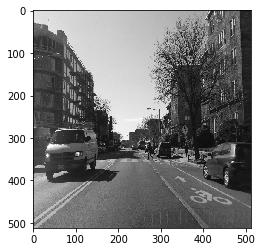

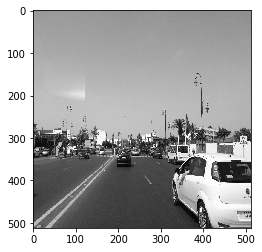

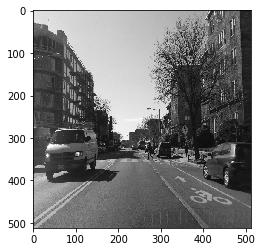

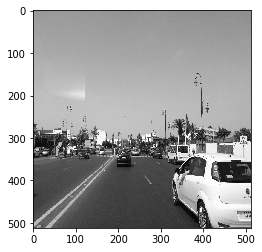

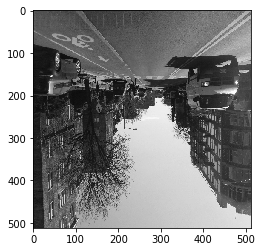

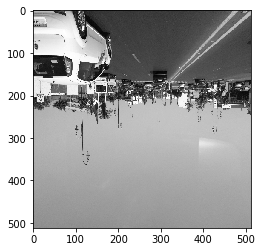

BATCH END


In [38]:
with tf.Session() as sess:
    for _ in range(batches_per_epoch_train):
        batch_xs, batch_ys = sess.run(train_batch_getter)
    print()
    for _ in range(batches_per_epoch_valid):
        batch_xs, batch_ys = sess.run([batch_xs_getter, batch_ys_getter])
        for img in batch_xs[:6]:
            show(img[:, :, 0])
        print('BATCH END')

In [39]:
from data import augment_flip

In [40]:
dataset_train.map(augment_flip)

<MapDataset shapes: ((2, ?, 512, 512, 1), (2, ?, 512, 512)), types: (tf.float32, tf.uint8)>

In [41]:
dataset_train.map(augment_flip).apply(tf.contrib.data.unbatch())

<FlatMapDataset shapes: ((?, 512, 512, 1), (?, 512, 512)), types: (tf.float32, tf.uint8)>

In [23]:
b = tf.placeholder(tf.bool)
c = tf.cond(b, lambda: train_batch_getter, lambda: valid_batch_getter)

In [48]:
sess = tf.Session()

In [30]:
print(sess.run(c, feed_dict={b: False}))

[16 17 18]


In [62]:
import numpy as np
batch_xs.shape

(8, 512, 512, 1)

In [68]:
sh = batch_xs.shape
grouped = np.reshape(batch_xs, (sh[0] // 2, 2, sh[1], sh[2], sh[3]))
grouped.shape

(4, 2, 512, 512, 1)

In [57]:
l = np.asarray([1, 2, 3, 4, 5, 6, 7, 8])
np.reshape(l, (4, 2))

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]])

In [70]:
np.mean(grouped, axis = 1).shape

(4, 512, 512, 1)

In [52]:
summ = tf.summary.image('imag', batch_xs, max_outputs=6)

In [53]:
summ_ = sess.run(summ)

In [54]:
writer = tf.summary.FileWriter('tmp_vis', sess.graph)

In [55]:
writer.add_summary(summ_)
writer.flush()

In [80]:
summ?

In [ ]:
tf.in